In [1]:
import mxnet as mx
import os
import multiprocessing
num_cpus = multiprocessing.cpu_count()

print("Number of CPUs:", num_cpus)

Number of CPUs: 16


In [2]:
# Global Libraries
import gluonnlp as nlp
from mxnet.contrib import amp
from mxnet.contrib import quantization

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sacremoses
import time
from tqdm.notebook import tqdm
import io
from importlib import reload

# Local Libraries
import nmt
import dataprocessor
import utils
import nmt.transformer_hparams
import transformer_model

# Hyperparameters for Dataloaders and Training
hparams = nmt.transformer_hparams

# Seeds for reproducibility
np.random.seed(100)
random.seed(100)
mx.random.seed(100)

## Datasets & DataLoaders

In [3]:
# WMT2016 Dataset
src_lang, tgt_lang = "en", "de"

wmt2016_val_data = nlp.data.WMT2016BPE(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

wmt2016_test_data = nlp.data.WMT2016BPE(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

# Text sentences for evaluation
wmt2016_val_text = nlp.data.WMT2016(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

wmt2016_test_text = nlp.data.WMT2016(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

src_max_len, tgt_max_len = 50, 50

In [4]:
# Split Val / Test sets
val_length = 150
test_length = 150

wmt2016_val_data._data[0] = wmt2016_val_data._data[0][:val_length]
wmt2016_val_data._data[1] = wmt2016_val_data._data[1][:val_length]
wmt2016_val_data._length = val_length

wmt2016_val_text._data[0] = wmt2016_val_text._data[0][:val_length]
wmt2016_val_text._data[1] = wmt2016_val_text._data[1][:val_length]
wmt2016_val_text._length = val_length

wmt2016_test_data._data[0] = wmt2016_test_data._data[0][-test_length:]
wmt2016_test_data._data[1] = wmt2016_test_data._data[1][-test_length:]
wmt2016_test_data._length = test_length

wmt2016_test_text._data[0] = wmt2016_test_text._data[0][-test_length:]
wmt2016_test_text._data[1] = wmt2016_test_text._data[1][-test_length:]
wmt2016_test_text._length = test_length

In [5]:
print("Length of val set  :", len(wmt2016_val_data))
print("Length of test set :", len(wmt2016_test_data))

Length of val set  : 150
Length of test set : 150


In [6]:
wmt2016_val_tgt_sentences = wmt2016_val_text.transform(lambda src, tgt: tgt, lazy=False)
wmt2016_test_tgt_sentences = wmt2016_test_text.transform(lambda src, tgt: tgt, lazy=False)

In [7]:
reload(transformer_model)

# For vocab
wmt_model_name = "transformer_en_de_512"
_, wmt_src_vocab, wmt_tgt_vocab = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=mx.cpu())

# Pre-processing WMT2016
wmt_transform_fn = dataprocessor.TrainValDataTransform(
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    src_max_len,
    tgt_max_len)

wmt2016_val_data_processed = wmt2016_val_data.transform(
    wmt_transform_fn)

wmt2016_test_data_processed = wmt2016_test_data.transform(
    wmt_transform_fn)

wmt2016_val_data_lengths = transformer_model.get_data_lengths(wmt2016_val_data_processed)
wmt2016_test_data_lengths = transformer_model.get_data_lengths(wmt2016_test_data_processed)

/home/sa_109024352321806746181/anaconda3/envs/mxnet/lib/python3.8/site-packages/gluonnlp/vocab/vocab.py:590: UserWarning: Detected a corrupted index in the deserialize vocabulary. For versions before GluonNLP v0.7 the index is corrupted by specifying the same token for different special purposes, for example eos_token == padding_token. Deserializing the vocabulary nevertheless.
  warnings.warn(


In [8]:
# Add Lengths to the datasets and indexes for validation and test
wmt2016_val_data_len_processed = wmt2016_val_data_processed.transform(transformer_model.get_length_index_fn(), lazy=False)
wmt2016_test_data_len_processed = wmt2016_test_data_processed.transform(transformer_model.get_length_index_fn(), lazy=False)

In [9]:
val_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack())

In [10]:
reload(transformer_model)

bucket_scheme = nlp.data.ExpWidthBucket(bucket_len_step=1.2)

wmt2016_val_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt2016_val_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size,
    shuffle=False)

wmt2016_test_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt2016_test_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size,
    shuffle=False)

In [11]:
num_workers = 0

wmt2016_val_data_loader = mx.gluon.data.DataLoader(
    wmt2016_val_data_len_processed,
    batch_sampler=wmt2016_val_batch_sampler,
    batchify_fn=val_batchify_fn,
    num_workers=num_workers,
    shuffle=False)

wmt2016_test_data_loader = mx.gluon.data.DataLoader(
    wmt2016_test_data_len_processed,
    batch_sampler=wmt2016_test_batch_sampler,
    batchify_fn=val_batchify_fn,
    num_workers=num_workers,
    shuffle=False)

## Naive CPU Inference

### Model

In [20]:
ctx = mx.cpu()
wmt_model_name = 'transformer_en_de_512'
wmt_transformer_pt_cpu, _, _ = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=ctx)

wmt_translator_pt_cpu = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_pt_cpu,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

loss_function = nlp.loss.MaskedSoftmaxCELoss()
wmt_detokenizer = nlp.data.SacreMosesDetokenizer()

#### Quantitative Evaluation: Test Loss and BLEU score

In [21]:
# Quantitative Evaluation
start_time = time.time()

wmt2016_test_loss, wmt2016_test_translation_out = transformer_model.evaluate(
    wmt_transformer_pt_cpu,
    wmt2016_test_data_loader,
    loss_function,
    wmt_translator_pt_cpu,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

wmt2016_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt2016_test_tgt_sentences],
    wmt2016_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

mx.nd.waitall()
print("Time (s):", time.time() - start_time)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt2016_test_loss, wmt2016_test_bleu_score * 100))

  0%|          | 0/21 [00:00<?, ?it/s]

Time (s): 373.5446252822876
WMT16 test loss: 1.53; test bleu score: 26.40


#### Qualitative Evaluation: Translation from English to German Example

In [14]:
mx.profiler.set_config(
    profile_all=True,
    aggregate_stats=True,
    continuous_dump=True,
    filename='profile_transformer_cpu.json')

In [15]:
# Qualitative Evaluation
reload(transformer_model)

print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne neue Dinge jeden Tag."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# Profiler start
mx.profiler.set_state('run')

translation_out = transformer_model.translate(
    wmt_translator_pt_cpu,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

# Wait until all operations have completed
mx.nd.waitall()
# Stop recording
mx.profiler.set_state('stop')
# Log results
mx.profiler.dump()

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne neue Dinge jeden Tag.
In English:
I learn new things every day.
The German translation is:
Ich lerne neue Dinge, die in jedem Fall auftreten.


## Optimal CPU Inference - Hybridation with MKLDNN and static ops

### Model

In [12]:
ctx = mx.cpu()
wmt_model_name = 'transformer_en_de_512'
wmt_transformer_pt_cpu_hybrid, _, _ = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=ctx)

wmt_transformer_pt_cpu_hybrid.hybridize(backend="MKLDNN", static_alloc=True, static_shape=True)

wmt_translator_pt_cpu_hybrid = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_pt_cpu_hybrid,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

wmt_detokenizer = nlp.data.SacreMosesDetokenizer()

loss_function = nlp.loss.MaskedSoftmaxCELoss()
loss_function.hybridize(backend="MKLDNN", static_alloc=True, static_shape=True)

#### Quantitative Evaluation: Test Loss and BLEU score

In [13]:
# Quantitative Evaluation
start_time = time.time()

wmt2016_test_loss, wmt2016_test_translation_out = transformer_model.evaluate(
    wmt_transformer_pt_cpu_hybrid,
    wmt2016_test_data_loader,
    loss_function,
    wmt_translator_pt_cpu_hybrid,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

wmt2016_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt2016_test_tgt_sentences],
    wmt2016_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

mx.nd.waitall()
print("Time (s):", time.time() - start_time)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt2016_test_loss, wmt2016_test_bleu_score * 100))

  0%|          | 0/21 [00:00<?, ?it/s]

Time (s): 312.5660226345062
WMT16 test loss: 1.53; test bleu score: 26.40


#### Qualitative Evaluation: Translation from English to German Example

In [14]:
mx.profiler.set_config(
    profile_all=True,
    aggregate_stats=True,
    continuous_dump=True,
    filename='profile_transformer_cpu_hybrid.json')

In [15]:
# Qualitative Evaluation
reload(transformer_model)

print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne neue Dinge jeden Tag."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# Profiler start
mx.profiler.set_state('run')

translation_out = transformer_model.translate(
    wmt_translator_pt_cpu_hybrid,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

# Wait until all operations have completed
mx.nd.waitall()
# Stop recording
mx.profiler.set_state('stop')
# Log results
mx.profiler.dump()

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne neue Dinge jeden Tag.
In English:
I learn new things every day.
The German translation is:
Ich lerne neue Dinge, die in jedem Fall auftreten.


## Naive GPU Inference

### Model

In [12]:
ctx = mx.gpu()
wmt_model_name = 'transformer_en_de_512'
wmt_transformer_pt_gpu, _, _ = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=ctx)

wmt_translator_pt_gpu = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_pt_gpu,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

loss_function = nlp.loss.MaskedSoftmaxCELoss()
wmt_detokenizer = nlp.data.SacreMosesDetokenizer()

[20:09:22] /work/mxnet/src/base.cc:79: cuDNN lib mismatch: linked-against version 8600 != compiled-against version 8204.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


#### Quantitative Evaluation: Test Loss and BLEU score

In [13]:
# Quantitative Evaluation
start_time = time.time()

wmt2016_test_loss, wmt2016_test_translation_out = transformer_model.evaluate(
    wmt_transformer_pt_gpu,
    wmt2016_test_data_loader,
    loss_function,
    wmt_translator_pt_gpu,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

wmt2016_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt2016_test_tgt_sentences],
    wmt2016_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

mx.nd.waitall()
print("Time (s):", time.time() - start_time)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt2016_test_loss, wmt2016_test_bleu_score * 100))

  0%|          | 0/21 [00:00<?, ?it/s]

Time (s): 61.67868137359619
WMT16 test loss: 1.53; test bleu score: 26.40


#### Qualitative Evaluation: Translation from English to German Example

In [14]:
mx.profiler.set_config(
    profile_all=True,
    aggregate_stats=True,
    continuous_dump=True,
    filename='profile_transformer_gpu.json')

In [15]:
# Qualitative Evaluation
reload(transformer_model)

print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne neue Dinge jeden Tag."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# Profiler start
mx.profiler.set_state('run')

translation_out = transformer_model.translate(
    wmt_translator_pt_gpu,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

# Wait until all operations have completed
mx.nd.waitall()
# Stop recording
mx.profiler.set_state('stop')
# Log results
mx.profiler.dump()

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne neue Dinge jeden Tag.
In English:
I learn new things every day.
The German translation is:
Ich lerne neue Dinge, die in jedem Fall auftreten.


## Optimal GPU Inference - Hybridation with static ops

### Model

In [12]:
ctx = mx.gpu()
wmt_model_name = 'transformer_en_de_512'
wmt_transformer_pt_gpu_hybrid, _, _ = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=ctx)

wmt_transformer_pt_gpu_hybrid.hybridize(static_alloc=True, static_shape=True)

loss_function = nlp.loss.MaskedSoftmaxCELoss()
loss_function.hybridize(static_alloc=True, static_shape=True)

wmt_detokenizer = nlp.data.SacreMosesDetokenizer()

wmt_translator_pt_gpu_hybrid = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_pt_gpu_hybrid,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

[20:22:59] /work/mxnet/src/base.cc:79: cuDNN lib mismatch: linked-against version 8600 != compiled-against version 8204.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


#### Quantitative Evaluation: Test Loss and BLEU score

In [13]:
# Quantitative Evaluation
start_time = time.time()

wmt2016_test_loss, wmt2016_test_translation_out = transformer_model.evaluate(
    wmt_transformer_pt_gpu_hybrid,
    wmt2016_test_data_loader,
    loss_function,
    wmt_translator_pt_gpu_hybrid,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

wmt2016_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt2016_test_tgt_sentences],
    wmt2016_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

mx.nd.waitall()
print("Time (s):", time.time() - start_time)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt2016_test_loss, wmt2016_test_bleu_score * 100))

  0%|          | 0/21 [00:00<?, ?it/s]

Time (s): 56.29795598983765
WMT16 test loss: 1.53; test bleu score: 26.40


#### Qualitative Evaluation: Translation from English to German Example

In [14]:
mx.profiler.set_config(
    profile_all=True,
    aggregate_stats=True,
    continuous_dump=True,
    filename='profile_transformer_gpu_hybrid.json')

In [15]:
# Qualitative Evaluation
reload(transformer_model)

print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne neue Dinge jeden Tag."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# Profiler start
mx.profiler.set_state('run')

translation_out = transformer_model.translate(
    wmt_translator_pt_gpu_hybrid,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

# Wait until all operations have completed
mx.nd.waitall()
# Stop recording
mx.profiler.set_state('stop')
# Log results
mx.profiler.dump()

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne neue Dinge jeden Tag.
In English:
I learn new things every day.
The German translation is:
Ich lerne neue Dinge, die in jedem Fall auftreten.


## ONNX Export

In [16]:
# ONNX library must be installed for this
# !python3 -m pip install onnx
onnx_file_name = "transformer_gpu_hybrid.onnx"

In [79]:
deeplab_pt_gpu_hybrid = gcv.model_zoo.get_model('deeplab_resnet101_coco', pretrained=True, ctx=mx.gpu())
deeplab_pt_gpu_hybrid.hybridize(static_alloc=True, static_shape=True)
deeplab_pt_gpu_hybrid(single_sample_gpu)

# Need to be exported externally for the symbols to be loaded
deeplab_pt_gpu_hybrid_filename = "deeplab_resnet101_coco_pt_gpu_hybrid"
deeplab_pt_gpu_hybrid.export(deeplab_pt_gpu_hybrid_filename)

# Files exported
sym_filename = deeplab_pt_gpu_hybrid_filename + "-symbol.json"
params_filename = deeplab_pt_gpu_hybrid_filename + "-0000.params"

# Verify generated files
assert os.path.exists(sym_filename)
assert os.path.exists(params_filename)

In [80]:
in_shapes = [single_sample_gpu.shape]
in_types = [mx.np.float32]

onnx_model_path = mx.onnx.export_model(
    sym_filename,
    params_filename,
    in_shapes,
    in_types,
    onnx_file_name)

onnx_model_path

'deeplab_resnet101_coco_pt_gpu_hybrid.onnx'

In [81]:
# Model Verification
import onnx

# Load the ONNX model
onnx_model = onnx.load_model(onnx_model_path)

# Check the ONNX graph
onnx.checker.check_graph(onnx_model.graph)

## TensorRT Export

In [82]:
import tensorrt as trt

In [83]:
trt_file_name = "deeplab_resnet101_coco_pt_gpu_hybrid.trt"

In [84]:
TRT_LOGGER = trt.Logger(trt.Logger.INFO)
builder = trt.Builder(TRT_LOGGER)
config = builder.create_builder_config()

explicit_batch = 1 << (int) (trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
deeplab_pt_gpu_hybrid_trt = builder.create_network(explicit_batch)

[10/21/2023-15:03:59] [TRT] [I] [MemUsageChange] Init CUDA: CPU +292, GPU +0, now: CPU 6240, GPU 6190 (MiB)
[10/21/2023-15:04:02] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +261, GPU +74, now: CPU 6555, GPU 6264 (MiB)
[10/21/2023-15:04:02] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage. See `CUDA_MODULE_LOADING` in https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars


In [85]:
with open(onnx_file_name, 'rb') as model:
    with trt.OnnxParser(deeplab_pt_gpu_hybrid_trt, TRT_LOGGER) as parser:
        assert parser.parse(model.read()) == True
    deeplab_pt_gpu_hybrid_engine_serialized = builder.build_serialized_network(deeplab_pt_gpu_hybrid_trt, config=config)

[10/21/2023-15:04:11] [TRT] [W] onnx2trt_utils.cpp:377: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[10/21/2023-15:04:13] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 7025, GPU 6272 (MiB)
[10/21/2023-15:04:13] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +10, now: CPU 7025, GPU 6282 (MiB)
[10/21/2023-15:04:13] [TRT] [I] Local timing cache in use. Profiling results in this builder pass will not be stored.
[10/21/2023-15:04:50] [TRT] [E] 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
[10/21/2023-15:04:50] [TRT] [E] 2: [virtualMemoryBuffer.cpp::resizePhysical::145] Error Code 2: OutOfMemory (no further information)
[10/21/2023-15:04:50] [TRT] [W] Requested amount of GPU memory (17179869184 bytes) could not be allocated. There may not be enough free memory for allocation to succeed.
[10/21/2023-15:04:50] [TRT] 

In [86]:
with open(trt_file_name, 'wb') as f:
    f.write(bytearray(deeplab_pt_gpu_hybrid_engine_serialized))

In [87]:
# Check it can be read back
runtime = trt.Runtime(TRT_LOGGER)

with open(trt_file_name, 'rb') as f:
    deeplab_pt_gpu_hybrid_engine_deserialized = runtime.deserialize_cuda_engine(f.read())

[10/21/2023-15:04:52] [TRT] [I] Loaded engine size: 246 MiB
[10/21/2023-15:04:52] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +1, GPU +8, now: CPU 7286, GPU 6522 (MiB)
[10/21/2023-15:04:52] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +248, now: CPU 0, GPU 248 (MiB)


In [92]:
deeplab_pt_cpu_q_hybrid.export('deeplab_pt_cpu_q_hybrid_sym')
sym, arg_params, aux_params = mx.model.load_checkpoint('deeplab_pt_cpu_q_hybrid_sym', 0)
mx.visualization.plot_network(sym)

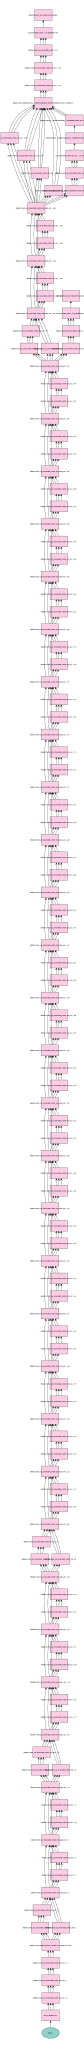